In [73]:
#Note tried something new to explore and applying models
#Libraries

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import matplotlib
import seaborn as sns
import warnings as wrn
from scipy.stats import shapiro
wrn.filterwarnings('ignore')
import matplotlib.animation as animation
from IPython.core.display import HTML

In [2]:
df = pd.read_csv("Heart Failure.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
#To be consistent with the feature description let's represent the platelets as kiloplatelets/mL

df.platelets = df.platelets/1000

In [6]:
df.head()

age  anaemia  creatinine_phosphokinase  ...  smoking  time  DEATH_EVENT
0  75.0        0                       582  ...        0     4            1
1  55.0        0                      7861  ...        0     6            1
2  65.0        0                       146  ...        1     7            1
3  50.0        1                       111  ...        0     7            1
4  65.0        1                       160  ...        0     8            1

[5 rows x 13 columns]

In [7]:
df["CPK"] = df["creatinine_phosphokinase"]
df = df.drop("creatinine_phosphokinase", axis=1)

In [8]:
# PALETTE

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

meshPalette = []
meshPalette_rev = []
nCol = 50

for i in range(nCol):
    meshPalette.append(colorFader("#71706E", "#990303", i/nCol))
    meshPalette_rev.append(colorFader("#990303","#9C9999", i/nCol))

cm = LinearSegmentedColormap.from_list("cmap_name", meshPalette, N=nCol)
cm_rev = LinearSegmentedColormap.from_list("cmap_name", meshPalette_rev, N=nCol)

In [9]:
#Feature distributions

numerical_features = ["age", "CPK", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

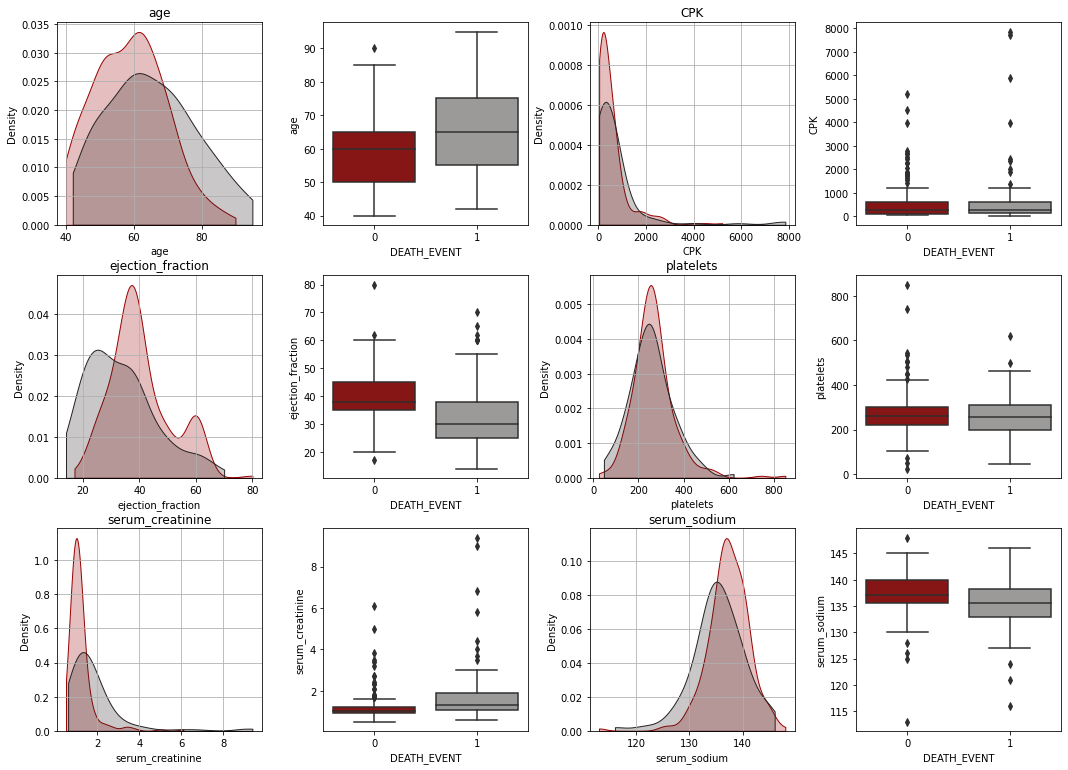

In [15]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = df, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])   

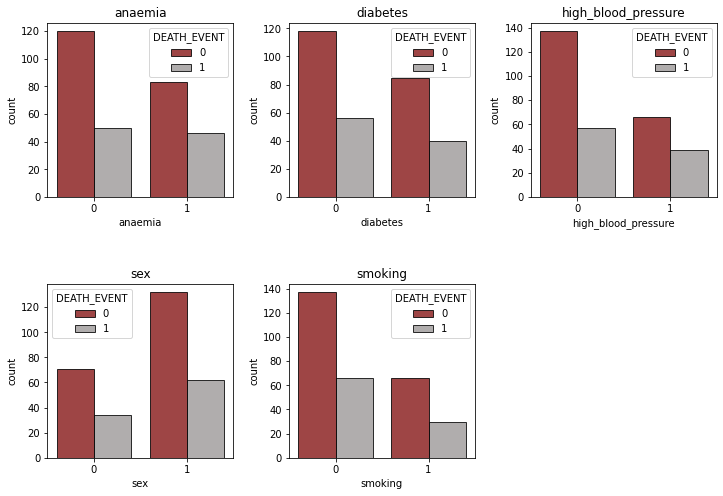

In [16]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue="DEATH_EVENT", palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

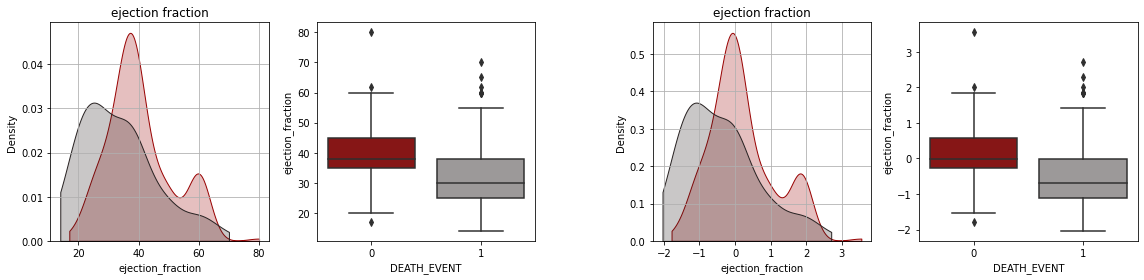

In [25]:
#Standardization

df_norm = df.copy()

for i, col in enumerate(numerical_features):
    df_norm[[col]] = StandardScaler(with_mean=True, with_std=True).fit_transform(df_norm[[col]])
    
plt.figure(figsize=(16, 4))
gs  = gridspec.GridSpec(1, 5, width_ratios=[1, 1 ,0.1, 1, 1])
plt.subplot(gs[0])   
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(df.loc[df["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(df.loc[df["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[1]) 
sns.boxplot(y = "ejection_fraction", data = df, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])  
plt.subplot(gs[2])
plt.axis('off')
plt.subplot(gs[3])
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(df_norm.loc[df["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(df_norm.loc[df["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[4])
sns.boxplot(y = "ejection_fraction", data = df_norm, x="DEATH_EVENT", palette = ["#990303", "#9C9999"]);  
plt.tight_layout()

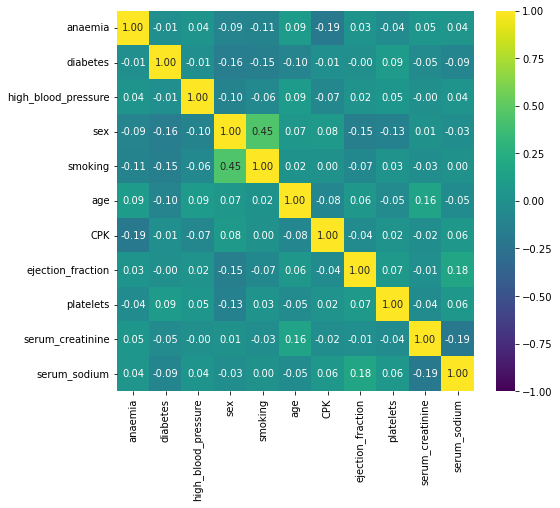

In [27]:
all_features = categorical_features.copy()
all_features.extend(numerical_features)
plt.figure(figsize=(8, 7))
sns.heatmap(df_norm[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap='viridis', annot=True, fmt='.2f');

In [29]:
index = [(feat, "statistic") for feat in numerical_features]
index.extend([(feat, "p-value") for feat in numerical_features])

index = pd.MultiIndex.from_tuples(index)

sw_df = pd.DataFrame(index=index,  columns = ["Both Classes", "DEATH_EVENT=0", "DEATH_EVENT=1"])

for feat in numerical_features:
    x = df_norm[feat]
    stat, p = shapiro(x)
    
    sw_df["Both Classes"].loc[(feat, "statistic")] = stat
    sw_df["Both Classes"].loc[(feat, "p-value")] = p
    
    x = df_norm.loc[df["DEATH_EVENT"]==0, feat]
    stat, p = shapiro(x)
    sw_df["DEATH_EVENT=0"].loc[(feat, "statistic")] = stat
    sw_df["DEATH_EVENT=0"].loc[(feat, "p-value")] = p
    
    x = df_norm.loc[df["DEATH_EVENT"]==1, feat]
    stat, p = shapiro(x)
    sw_df["DEATH_EVENT=1"].loc[(feat, "statistic")] = stat
    sw_df["DEATH_EVENT=1"].loc[(feat, "p-value")] = p
    
sw_df = sw_df.unstack()

In [30]:
pd.set_option('display.float_format', '{:.3g}'.format)
sw_df

Both Classes            ... DEATH_EVENT=1          
                       p-value statistic  ...       p-value statistic
CPK                   7.05e-28     0.514  ...      1.99e-17     0.439
age                   5.35e-05     0.975  ...        0.0221     0.969
ejection_fraction     7.22e-09     0.947  ...      4.54e-05     0.927
platelets             2.88e-12     0.912  ...        0.0336     0.971
serum_creatinine      5.39e-27     0.551  ...      1.28e-14     0.608
serum_sodium          9.22e-10     0.939  ...       0.00384     0.958

[6 rows x 6 columns]

In [32]:
train_ratio = 0.75
val_ratio = 0.25

ho_train_df, ho_val_df = train_test_split(df_norm, train_size = train_ratio, random_state=42)
unnorm_ho_train_df, unnorm_ho_val_df = train_test_split(df, train_size = train_ratio, random_state=42)

print("Holdout split:")
print(f"Train samples: {len(ho_train_df)}")
print(f"Validation/Test samples: {len(ho_val_df)}")

Holdout split:
Train samples: 224
Validation/Test samples: 75


Feature selection

Mutual information
Mutual information can be useful when it's needed to assess the dependence of a feature with respect to the target.
MI is always > 0 and higher values indicate stronger dependence.

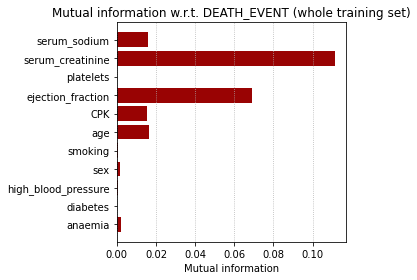

In [35]:
MI = (mutual_info_classif(ho_train_df[all_features],
                             ho_train_df["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))

plt.figure(figsize=(5.4, 4))
plt.barh(y=all_features, width=MI, color="#990303")
plt.title("Mutual information w.r.t. DEATH_EVENT (whole training set)");
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':');
plt.tight_layout();

Chi-squared test
For the categorical features we can further test the dependence w.r.t. the target with a chi-squared test.
A lower value of the statistic means a stronger independence.

Chi-squared test is performed starting from the contingency table, for instance:

In [37]:
print("Observed")
ctable = pd.crosstab(ho_train_df["anaemia"], ho_train_df["DEATH_EVENT"])
ctable.columns = ["DEATH_EVENT=0", "DEATH_EVENT=1"]
ctable.index = ["anaemia=0", "anaemia=1"]
ctable.loc["Total"] = ctable.sum()
ctable["Total"] = ctable.sum(axis=1)
ctable

Observed


DEATH_EVENT=0  DEATH_EVENT=1  Total
anaemia=0             94             34    128
anaemia=1             65             31     96
Total                159             65    224

In [38]:
print("Expected")
contingency_table = pd.crosstab(ho_train_df["anaemia"], ho_train_df["DEATH_EVENT"])
stat, p, dof, expected = chi2_contingency(contingency_table)
expected = pd.DataFrame(expected)
expected.columns = ["DEATH_EVENT=0", "DEATH_EVENT=1"]
expected.index = ["anaemia=0", "anaemia=1"]
expected

Expected


DEATH_EVENT=0  DEATH_EVENT=1
anaemia=0           90.9           37.1
anaemia=1           68.1           27.9

In [39]:
def chi2_test(df, feat1, feat2):

    contingency_table = pd.crosstab(df[feat1], df[feat2])
    
    stat, p, dof, expected = chi2_contingency(contingency_table)
    prob = 0.95 # alpha=0.05
    critical = chi2.ppf(prob, dof)
    alpha = 1.0 - prob
    
    return stat, p

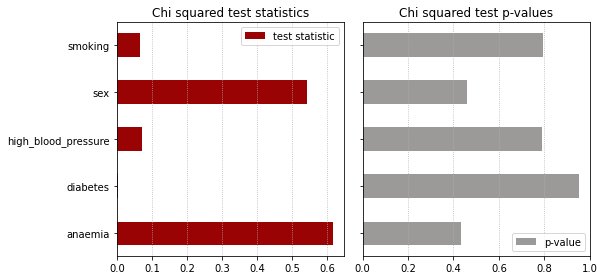

In [40]:
stats = []
p_values = []

for feat in categorical_features:
        
    stat, p = chi2_test(ho_train_df, feat, "DEATH_EVENT")
    stats.append(stat)
    p_values.append(p)        

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(8.5, 4)
axes[0].barh(y=categorical_features, width=stats, color="#990303", label="test statistic", height=0.5)
axes[0].set_title("Chi squared test statistics")

axes[1].barh(y=categorical_features, width=p_values, color="#9C9999", label="p-value", height=0.5)
axes[1].set_title("Chi squared test p-values")

axes[0].xaxis.grid(True, linestyle=':');
axes[1].xaxis.grid(True, linestyle=':');

axes[0].legend(loc=1)
axes[1].legend(loc=4)

fig.subplots_adjust(wspace=0.06)
plt.tight_layout()

Results
From the results we can say that smoking, high_blood_pressure, diabetes and platelets can be easily dropped.
Altough sexand anaemia produce still very low values of the statistic, they are kept. (In this way we can see how models handle a mix of continouos and binary features)

In [41]:
kfold_train_df, kfold_val_df = ho_train_df.copy(), ho_val_df.copy()

all_features = ['anaemia', 'sex', 'age', 'CPK', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']

Mutual information with respect to DEATH_EVENT (5 folds)


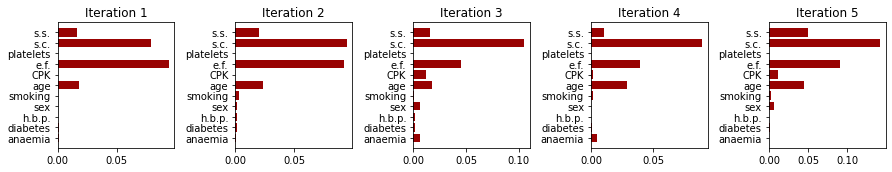

In [42]:
#Kfold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12.5, 2.5))

print("Mutual information with respect to DEATH_EVENT (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    MI=(mutual_info_classif(kfold_train_df.iloc[train_idx][categorical_features+numerical_features],
                             kfold_train_df.iloc[train_idx]["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.','sex', 'smoking', 'age', 'CPK', 'e.f.', 'platelets',
         's.c.', 's.s.'], width=MI, color="#990303", label="test statistic")
    
plt.tight_layout()  

Chi squared test statistics (5 folds)


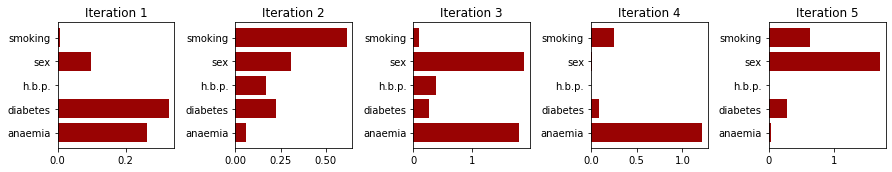

In [43]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(12.5, 2.5))
print("Chi squared test statistics (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    stats = []
    p_values = []

    for feat in categorical_features:

        stat, p = chi2_test(kfold_train_df.iloc[train_idx], feat, "DEATH_EVENT")
        stats.append(stat)
        p_values.append(p)
    
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.', 'sex', 'smoking'], width=stats, color="#990303", label="test statistic")
plt.tight_layout()

In [44]:
numerical_features = ['age', 'CPK', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
all_features_kfold = [
    ["anaemia", "diabetes"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
    ["anaemia", "sex"]+numerical_features,
    ["anaemia", "smoking"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
]

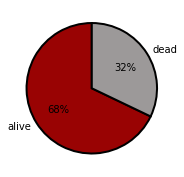

In [47]:
plt.figure(figsize=(3, 3))
plt.pie(df["DEATH_EVENT"].value_counts(),
        labels = ["alive", "dead"],
        colors = ["#990303", "#9C9999"], 
        wedgeprops={'edgecolor':'black', 'linewidth': 2}, 
        autopct = lambda y: str(round(y))+"%",
        startangle=90);

Random oversampling
Random oversampling is a resample technique that consists in taking the under-represented class samples and sampling new samples from them until the classes are balanced.
During training, random oversampling needs to be done after the subdivision into train, validation and test to avoid data leakage.
The idea is that, not being able to sample more samples from the true distribution, we sample them from the empirical distribution coming from the samples that we already have.

In [48]:
n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = ho_train_df[ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)

ho_train_df_rs = ho_train_df.append(new_samples)

new_samples = unnorm_ho_train_df[unnorm_ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)
unnorm_ho_train_df_rs = unnorm_ho_train_df.append(new_samples)

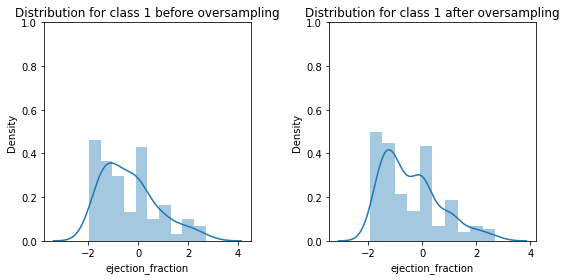

In [49]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Distribution for class 1 before oversampling")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("Distribution for class 1 after oversampling")
sns.distplot(ho_train_df_rs[ho_train_df_rs.DEATH_EVENT==1].ejection_fraction, bins=nbins);
plt.tight_layout()

In [50]:
#SMOTE

def rand_jitter(arr):
    np.random.seed(42)
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [51]:
norm = np.linalg.norm
import random
from random import sample 

def SMOTE(data, sampling_rate, n_neigh, random_state=42):
    random.seed(random_state)
    new_samples = []
    
    if sampling_rate==0:
        return
    
    if sampling_rate>n_neigh: return      
    data = data.reset_index(drop=True)

    n_samples = data.count()[0]

    for i in range(n_samples):
        dists = []
        for j in range(n_samples):
            if i==j: continue
            dists.append((j, norm(data.loc[i]-data.loc[j])))    
        
        topk = sorted(dists, key=lambda s: s[1])[:n_neigh]
        neighs = sample(topk, sampling_rate)

        for neigh in neighs:
            alpha = random.random()
            new_samples.append(data.loc[i] + alpha * (data.loc[neigh[0]]-data.loc[i]))
            
    return new_samples

In [52]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

In [55]:
fig.set_size_inches(4, 4);
fig.set_dpi(100)

def animate_func(i):
    new_samples = SMOTE(df[df["DEATH_EVENT"]==1][["ejection_fraction", "serum_creatinine"]], sampling_rate = i, n_neigh = 20)
    sm_hf = df.copy()

    if new_samples:
        sm_hf = df.append(new_samples)
        
    sm_hf["DEATH_EVENT"].fillna(1, inplace=True)
    
    ax.clear();

    ax.set_ylim(0, 17.5);
    ax.set_xlim(10, 90);
    
    ax.scatter((sm_hf[sm_hf["DEATH_EVENT"]==1]["ejection_fraction"]),
            sm_hf[sm_hf["DEATH_EVENT"]==1]["serum_creatinine"], s=5, label="DEAD", color="#71706E", alpha=1)
    ax.scatter(rand_jitter(sm_hf[sm_hf["DEATH_EVENT"]==0]["ejection_fraction"]),
            sm_hf[sm_hf["DEATH_EVENT"]==0]["serum_creatinine"], s=5, label="ALIVE", color="#990303", alpha=1)
    ax.legend()
    
    ax.set_xlabel("ejection_fraction")
    ax.set_ylabel("serum_creatinine")
    ax.set_title(f"Sampling rate: {i}, ALIVE = {sm_hf[sm_hf.DEATH_EVENT==0].count()[3]}, DEAD = {sm_hf[sm_hf.DEATH_EVENT==1].count()[3]}")

    return [fig]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 10,
                               interval = 100, # in ms
                               );

HTML(anim.to_jshtml())

In [56]:
n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = SMOTE(ho_train_df[ho_train_df["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)

# categorical attributes need to be fixed
for s in new_samples:
    s["anaemia"] = np.round(s["anaemia"])
    s["sex"] = np.round(s["sex"])

ho_train_df_sm = ho_train_df.append(new_samples)
ho_train_df_sm["DEATH_EVENT"].fillna(1, inplace=True)


new_samples = SMOTE(unnorm_ho_train_df[unnorm_ho_train_df["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)

# categorical attributes need to be fixed
for s in new_samples:
    s["anaemia"] = np.round(s["anaemia"])
    s["sex"] = np.round(s["sex"])

unnorm_ho_train_df_sm = unnorm_ho_train_df.append(new_samples)
unnorm_ho_train_df_sm["DEATH_EVENT"].fillna(1, inplace=True)

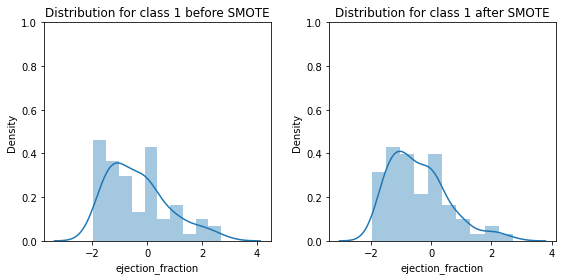

In [57]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Distribution for class 1 before SMOTE")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("Distribution for class 1 after SMOTE")
sns.distplot(ho_train_df_sm[ho_train_df_sm.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.tight_layout();

In [58]:
w = len(ho_train_df) / (2 * np.bincount(ho_train_df.DEATH_EVENT))
print(f"class 0: {w[0]} \nclass 1: {w[1]}")

class 0: 0.7044025157232704 
class 1: 1.7230769230769232


In [59]:
# KFOLD

class KFold():
    
    # caching smote results 
    smote_folds = None
    smote_labels = None
    
    def __init__(self, all_features_kfold, random_state=42):
        self.smote_folds = []
        self.smote_labels = []
        self.features = all_features_kfold
        
        self.kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    def fit_predict(self, model, X, y, threshold = None, resampling = None, cached = False):
        acc, rec, pre, f1 = 0, 0, 0, 0
        
        if resampling=="SMOTE" and not cached:
            self.smote_folds = []
            self.smote_labels = []
        
        for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
           
            X_fold = X[self.features[i]] # for each fold we have different features
        
            X_train, X_val = X_fold.iloc[train_idx], X_fold.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if resampling=="oversampling":
                n_to_sample = len(X_train[y_train==0]) - len(X_train[y_train==1])
                new_samples = X_train[y_train==1].sample(n_to_sample, replace=True, random_state=42)
                
                X_train = X_train.append(new_samples)
                y_train = y_train.append(pd.Series([1]*len(new_samples)))
                
                X_train = X_train.reset_index(drop=True)
                y_train = y_train.reset_index(drop=True)

            if resampling=="SMOTE": 
                if not cached or len(self.smote_folds)<5 or len(self.smote_labels)<5:
                    n_to_sample = len(X_train[y_train==0]) - len(X_train[y_train==1])
                    new_samples = SMOTE(X_train[y_train==1], sampling_rate = 1, n_neigh = 50)

                    # categorical attributes need to be fixed
                    for s in new_samples:
                        if "anaemia" in  s.index:
                            s["anaemia"] = np.round(s["anaemia"])
                        if "high_blood_pressure" in s.index:
                            s["high_blood_pressure"] = np.round(s["high_blood_pressure"])
                        if "sex" in  s.index:
                            s["sex"] = np.round(s["sex"])
                        if "smoking" in  s.index:
                            s["smoking"] = np.round(s["smoking"])
                        if "diabetes" in  s.index:
                            s["diabetes"] = np.round(s["diabetes"])
                                            
                    X_train = X_train.append(new_samples, ignore_index=True)
                    y_train = y_train.append(pd.Series([1]*len(new_samples)))
                    
                    X_train = X_train.reset_index(drop=True)
                    y_train = y_train.reset_index(drop=True)
                    
                    # cache smoted folds
                    self.smote_folds.append(X_train)
                    self.smote_labels.append(y_train)
                    
                else:
                    # use cached folds
                    X_train = self.smote_folds[i]
                    y_train = self.smote_labels[i]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            if threshold:
                preds[preds>=threshold] = 1
                preds[preds<threshold] = 0

            acc += accuracy_score(y_val, preds)
            pre += precision_score(y_val, preds)
            rec += recall_score(y_val, preds)
            f1 += f1_score(y_val, preds)

        acc /= 5
        pre /= 5
        rec /= 5
        f1 /= 5
        return acc, pre, rec, f1

In [60]:
# initialize kfold object
kfold = KFold(all_features_kfold, random_state=42)

In [61]:
#Classification Model
#More Libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

In [62]:
final_results = pd.DataFrame(columns=["Model", "Holdout Original","Holdout Oversampling", "Holdout SMOTE", 
                   "Holdout class-weight=balanced", "KFold Original", "KFold Oversampling",
                   "KFold SMOTE", "KFold class-weight=balanced"])

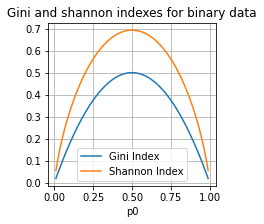

In [63]:
#DT

p = np.linspace(1e-2, 1-1e-2, 100)

plt.figure(figsize=(3, 3))
plt.plot(p, [1-pj**2-(1-pj)**2 for pj in p], label="Gini Index")
plt.plot(p, [-((pj*np.log(pj))+((1-pj)*np.log(1-pj))) for pj in p], label="Shannon Index")
plt.grid()
plt.legend();
plt.xlabel("p0")
plt.title("Gini and shannon indexes for binary data");

In [65]:
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

depth = range(1, 6)
h = 0.03
x_min, x_max = df["ejection_fraction"].min() - 1, df["ejection_fraction"].max() + 1
y_min, y_max = df["serum_creatinine"].min() - .5, df["serum_creatinine"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

fig.set_size_inches(14, 7);
def animate_func(i):
    
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth[i], random_state=42, )
    dt.fit(df[["ejection_fraction", "serum_creatinine"]], df.DEATH_EVENT)
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)
    ax1.scatter(df[df["DEATH_EVENT"]==0]["ejection_fraction"],
                df[df["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(df[df["DEATH_EVENT"]==1]["ejection_fraction"],
                df[df["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    
    tree.plot_tree(dt,  feature_names=["e.f.", "s.c."], filled=True,
                   label='none', ax=ax2, rounded=True, proportion=True, impurity=False);
    ax2.set_title(f"Decision tree (depth: {i+1})")
    
    fig.tight_layout()
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(depth),
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())

In [66]:
depth = range(1, 12)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df_rs[all_features], unnorm_ho_train_df_rs['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    rs_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df_sm[all_features], unnorm_ho_train_df_sm['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    sm_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    no_rs_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    w_acc.append(accuracy_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_rec.append(recall_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_pre.append(precision_score(unnorm_ho_val_df["DEATH_EVENT"], pred))
    w_f1.append(f1_score(unnorm_ho_val_df["DEATH_EVENT"], pred))

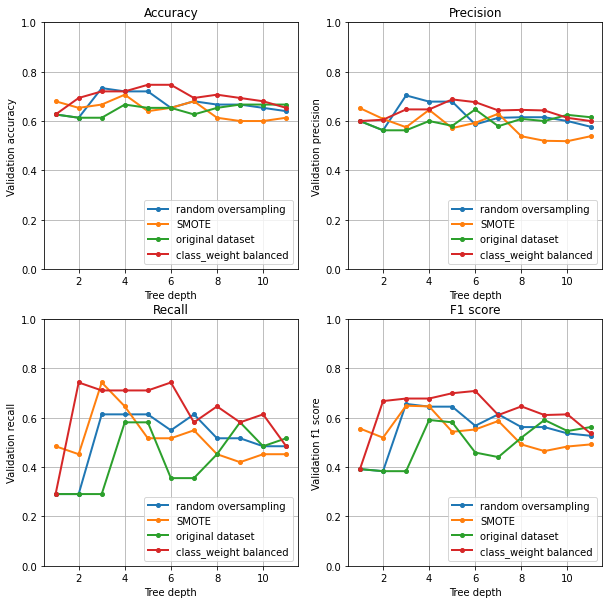

In [67]:
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(depth), rs_acc, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_acc, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_acc, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_acc, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("Tree depth")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)    
plt.plot(list(depth), rs_pre, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_pre, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_pre, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_pre, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("Tree depth")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(depth), rs_rec, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_rec, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_rec, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_rec, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("Tree depth")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(depth), rs_f1, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_f1, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), no_rs_f1, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_f1, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("Tree depth")
plt.title("F1 score");

In [68]:
# KFOLD

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          cached=True, resampling="SMOTE")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'])
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    acc, rec, pre, f1 = kfold.fit_predict(dt, ho_train_df, ho_train_df['DEATH_EVENT'])
    w_acc.append(acc)
    w_rec.append(rec)
    w_pre.append(pre)
    w_f1.append(f1)

In [69]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

fig.set_size_inches(20, 15);
def animate_func(i):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i+1, random_state=42, class_weight='balanced')
    dt.fit(unnorm_ho_train_df[all_features], unnorm_ho_train_df['DEATH_EVENT'])
    pred = dt.predict(unnorm_ho_val_df[all_features])
    
    tree.plot_tree(dt,  feature_names=all_features, filled=True, label='all', ax=ax, rounded=True, proportion=True);
    ax.set_title(f"Decision tree (depth: {i+1})", fontsize=25)
    # value are float variables due to class_weight="balanced"
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 11,
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())


In [70]:
#Random Forest

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

max_features='sqrt' # square root of number of features       
max_depth = 14
depth = range(1, max_depth)
n_trees = [5, 10, 20, 50, 100]
n_vals = len(n_trees)

rs_acc, rs_oob_acc, rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc, sm_oob_acc, sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
no_rs_acc, no_rs_oob_acc, no_rs_rec, no_rs_pre, no_rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc, w_oob_acc, w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_oob_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], [], []
    sm_acc[i], sm_oob_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], [], []
    no_rs_acc[i], no_rs_oob_acc[i], no_rs_rec[i], no_rs_pre[i], no_rs_f1[i] = [], [], [], [], []
    w_acc[i], w_oob_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], [], []

    for d in depth: 
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)
        
        rf.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        rs_oob_acc[i].append(rf.oob_score_)
        rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        sm_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        sm_oob_acc[i].append(rf.oob_score_)
        sm_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        sm_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        sm_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        no_rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_oob_acc[i].append(rf.oob_score_)
        no_rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight='balanced')

        rf.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
        pred = rf.predict(ho_val_df[all_features]);
        w_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        w_oob_acc[i].append(rf.oob_score_)
        w_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        w_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        w_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [71]:
%matplotlib notebook
plt.ioff()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
%matplotlib inline 
plt.ion()

In [72]:
fig.set_size_inches(7, 7);
def animate_func(i):  
    # accuracy
    ax1.clear();
    ax1.plot(list(depth), rs_acc[i], label="random oversampling", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), sm_acc[i], label="SMOTE", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), no_rs_acc[i], label = "original dataset", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), w_acc[i], label = "class_weight balanced", linewidth=1.5, marker='o', markersize=3);

    ax1.plot(list(depth), rs_oob_acc[i], label="random oversampling OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#287CB7");
    ax1.plot(list(depth), sm_oob_acc[i], label="SMOTE OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#FE8417");
    ax1.plot(list(depth), no_rs_oob_acc[i], label = "original dataset OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#34A334");
    ax1.plot(list(depth), w_oob_acc[i], label = "class_weight balanced OOB", linewidth=1, linestyle='dashed', alpha=0.8, color = "#D62728");

    ax1.legend(fontsize=7, loc=3);
    ax1.grid(True);
    ax1.set_ylim(0, 1);
    ax1.set_ylabel("Validation accuracy");
    ax1.set_xlabel("Single tree depth");
    ax1.set_title(f"Accuracy (n_trees: {n_trees[i]})");

    # precision
    ax2.clear();
    ax2.plot(list(depth), rs_pre[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), sm_pre[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), no_rs_pre[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), w_pre[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax2.legend(fontsize=7, loc=3);
    ax2.grid(True);
    ax2.set_ylim(0, 1);
    ax2.set_ylabel("Validation precision");
    ax2.set_xlabel("Single tree depth");
    ax2.set_title(f"Precision (n_trees: {n_trees[i]})");

    # recall
    ax3.clear();
    ax3.plot(list(depth), rs_rec[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), sm_rec[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), no_rs_rec[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), w_rec[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax3.legend(fontsize=7, loc=4);
    ax3.grid(True);
    ax3.set_ylim(0, 1);
    ax3.set_ylabel("Validation recall");
    ax3.set_xlabel("Single tree depth");
    ax3.set_title(f"Recall (n_trees: {n_trees[i]})");

    # f1 score
    ax4.clear();
    ax4.plot(list(depth), rs_f1[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), sm_f1[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), no_rs_f1[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), w_f1[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax4.legend(fontsize=7, loc=4);
    ax4.grid(True);
    ax4.set_ylim(0, 1);
    ax4.set_ylabel("Validation f1 score");
    ax4.set_xlabel("Single tree depth");
    ax4.set_title(f"F1 score (n_trees: {n_trees[i]})");
    
    fig.tight_layout()
    return [fig];

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_vals,
                               interval = 100, # in ms
                               );
HTML(anim.to_jshtml())

In [74]:
rs_acc, rs_oob_acc, rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc, sm_oob_acc, sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc, w_oob_acc, w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_oob_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], [], []
    sm_acc[i], sm_oob_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], [], []
    w_acc[i], w_oob_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], [], []

    for d in depth: 
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)
        
        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                          resampling="oversampling")
        rf.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
        rs_acc[i].append(acc)
        
        rs_rec[i].append(rec)
        rs_pre[i].append(pre)
        rs_f1[i].append(f1)

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    random_state=42, class_weight=None)

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'], 
                                               resampling="SMOTE", cached=True)
        sm_acc[i].append(acc)
        sm_rec[i].append(rec)
        sm_pre[i].append(pre)
        sm_f1[i].append(f1)
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'])
        no_rs_acc[i].append(acc)
        no_rs_rec[i].append(rec)
        no_rs_pre[i].append(pre)
        no_rs_f1[i].append(f1)

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight='balanced')

        acc, rec, pre, f1 = kfold.fit_predict(rf, ho_train_df, ho_train_df['DEATH_EVENT'])
        w_acc[i].append(acc)
        w_rec[i].append(rec)
        w_pre[i].append(pre)
        w_f1[i].append(f1)

In [75]:
#Linear Regression

# holdout

threshold=0.5

# oversampled 
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_rs = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# SMOTE 
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_sm = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
sm_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
sm_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
sm_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
sm_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# not oversampled
lr = LinearRegression(fit_intercept=True)
lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_no_rs = pred.copy()
pred[pred>=0.5]=1
pred[pred<0.5]=0
no_rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [76]:
# oversampled 
lr = LinearRegression(fit_intercept=True)
rs_acc, rs_rec, rs_pre, rs_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="oversampling")
    
# SMOTE 
lr = LinearRegression(fit_intercept=True)
sm_acc, sm_rec, sm_pre, sm_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5, resampling="SMOTE", cached=True)
    
# not oversampled
lr = LinearRegression(fit_intercept=True)
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

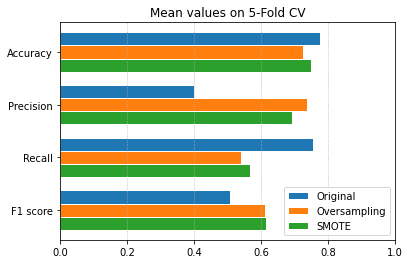

In [77]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.25
space=0.0
 
bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]

plt.barh(r3, bars1, label="Original",height=barWidth, edgecolor='white')
plt.barh(r2, bars2, label="Oversampling", height=barWidth, edgecolor='white')
plt.barh(r1, bars3, label="SMOTE", height=barWidth, edgecolor='white')

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

In [78]:
# area under the curve evaluation
def roc_area(tpr, fpr):
    area = 0
    for i in range(len(tpr)-1):
        base = fpr[i+1]-fpr[i]
        h = tpr[i]
        area += base*h
        
    return round(area, 3)

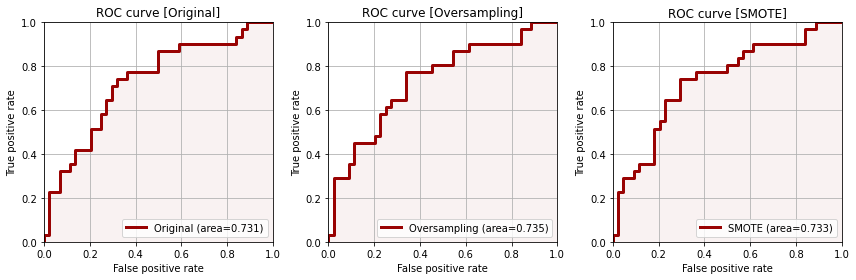

In [79]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_sm)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(1, 3, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(1, 3, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303');
plt.tight_layout()

In [80]:
c = 1
penalty = "l2"
solver = "liblinear"
multi_class = "auto"

# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_rs = lr.predict_proba(ho_val_df[all_features])[:, 1]

rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_sm = lr.predict_proba(ho_val_df[all_features])[:, 1]

sm_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
sm_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
sm_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
sm_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))
    
# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_no_rs = lr.predict_proba(ho_val_df[all_features])[:, 1]

no_rs_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
no_rs_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])
raw_pred_w = lr.predict_proba(ho_val_df[all_features])[:, 1]

w_acc=(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
w_rec=(recall_score(ho_val_df["DEATH_EVENT"], pred))
w_pre=(precision_score(ho_val_df["DEATH_EVENT"], pred))
w_f1=(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [81]:
# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

rs_acc, rs_rec, rs_pre, rs_f1 = kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                  threshold=0.5, resampling="oversampling")
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

sm_acc, sm_rec, sm_pre, sm_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'],
                                                 threshold=0.5, resampling="SMOTE", cached=True)
    
# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

w_acc, w_rec, w_pre, w_f1= kfold.fit_predict(lr, ho_train_df, ho_train_df['DEATH_EVENT'], threshold=0.5)

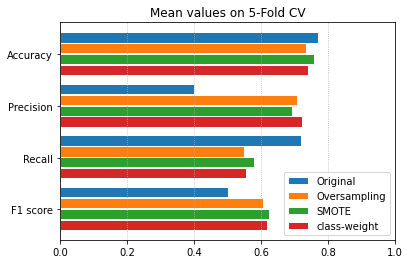

In [84]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space=0.01
 
bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]
bars4 = [w_f1, w_rec, w_pre, w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight", height=barWidth, edgecolor='white', )

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

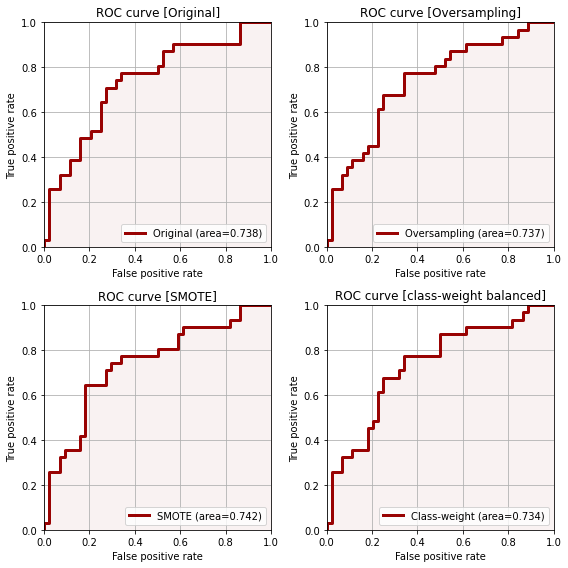

In [85]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_df["DEATH_EVENT"], raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='#990303')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='#990303')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"Class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='#990303')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='#990303');

plt.tight_layout()

In [87]:
#KNN

n_neigh = [1, 5, 10, 20, 50]
metric = "minkowski"
p = [2, 3, 4, 5]
h = 0.03

x_min, x_max = df_norm["ejection_fraction"].min() - .5, df_norm["ejection_fraction"].max() + .5
y_min, y_max = df_norm["serum_creatinine"].min() - .5, df_norm["serum_creatinine"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [89]:
print("Evaluting different number of nearest neighbors")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(n_neigh[i], weights="uniform", metric=metric, p=2)
    knn.fit(df_norm[["ejection_fraction", "serum_creatinine"]], df_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax1.scatter(df_norm[df_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(df_norm[df_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) n_neigh={n_neigh[i]}")
    
    # distance
    knn = KNeighborsClassifier(n_neigh[i], weights="distance", metric=metric, p=2)
    knn.fit(df_norm[["ejection_fraction", "serum_creatinine"]], df_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax2.scatter(df_norm[df_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax2.scatter(df_norm[df_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax2.set_xlabel("ejection_fraction")
    ax2.set_ylabel("serum_creatinine")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) n_neigh={n_neigh[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(n_neigh),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Evaluting different number of nearest neighbors


In [91]:
print("Evaluating different values of p for minkowski distance metric")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(10, weights="uniform", metric=metric, p=p[i])
    knn.fit(df_norm[["ejection_fraction", "serum_creatinine"]], df_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax1.scatter(df_norm[df_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax1.scatter(df_norm[df_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax1.set_xlabel("ejection_fraction")
    ax1.set_ylabel("serum_creatinine")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) p={p[i]}")
    
    # distance
    knn = KNeighborsClassifier(10, weights="distance", metric=metric, p=p[i])
    knn.fit(df_norm[["ejection_fraction", "serum_creatinine"]], df_norm['DEATH_EVENT'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cm_rev)

    ax2.scatter(df_norm[df_norm["DEATH_EVENT"]==0]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==0]["serum_creatinine"], label="alive", color="#990303", edgecolor='BLACK')
    ax2.scatter(df_norm[df_norm["DEATH_EVENT"]==1]["ejection_fraction"],
                    df_norm[df_norm["DEATH_EVENT"]==1]["serum_creatinine"], label="dead", color="#9C9999", edgecolor='BLACK')

    ax2.set_xlabel("ejection_fraction")
    ax2.set_ylabel("serum_creatinine")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) p={p[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(p),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Evaluating different values of p for minkowski distance metric


In [92]:
#Weights = original
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
       
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [93]:
# k fold
rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):
       
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
        
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)

K-Fold cross-validation metrics (5 folds)


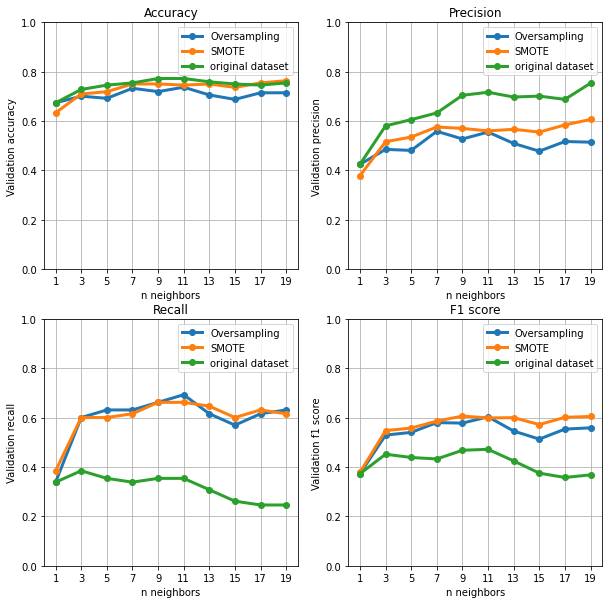

In [94]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

In [95]:
#Weights = distance
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df_sm[all_features], ho_train_df_sm['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    sm_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    sm_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    sm_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))
        
    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT']);
    pred = knn.predict_proba(ho_val_df[all_features]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_rec.append(recall_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_pre.append(precision_score(ho_val_df["DEATH_EVENT"], pred))
    no_rs_f1.append(f1_score(ho_val_df["DEATH_EVENT"], pred))

In [96]:
# k fold

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)  
    
    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_df, ho_train_df['DEATH_EVENT'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)

K-Fold cross-validation metrics (5 folds)


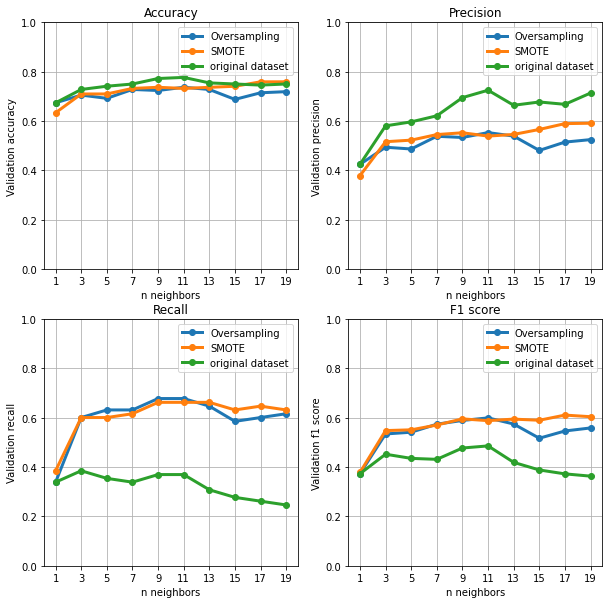

In [97]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

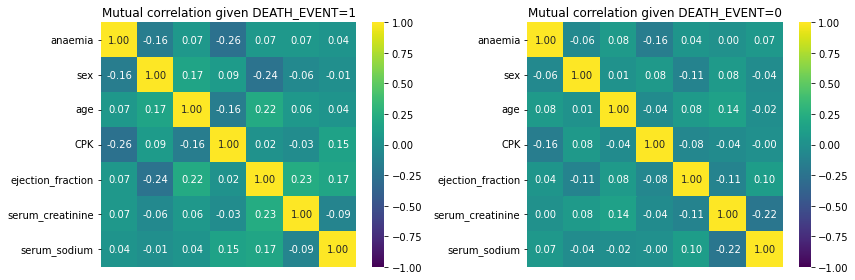

In [100]:
#NB

dead = df_norm[df_norm["DEATH_EVENT"]==1][all_features].corr(method='pearson')
alive = df_norm[df_norm["DEATH_EVENT"]==0][all_features].corr(method='pearson')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Mutual correlation given DEATH_EVENT=1")
sns.heatmap(dead, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap='viridis', fmt='.2f')

plt.subplot(1, 2, 2)
plt.title("Mutual correlation given DEATH_EVENT=0")
sns.heatmap(alive, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap='viridis', fmt='.2f')

plt.tight_layout()

Conslucion

Here we can see the results obtained with different models and different rebalancing techniques for the Hearth Disease dataset.
Both accuracy and f1 score (inside parenthesis) are showed.
Best overall model seems to be the random forest trained on the oversampled dataset, that delivers the best results in terms of accuracy and f1 score.